# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [7]:
# Load pickled data
import pickle

# Completed: Fill this in based on where you saved the training and testing data

training_file = "/home/carnd/Data/train.p"
validation_file= "/home/carnd/Data/valid.p"
testing_file = "/home/carnd/Data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from skimage import transform
from skimage import color as skc
%matplotlib inline

# Number of training examples
n_train = len(y_train)

# Number of validation examples
n_validation = len(y_valid)

# Number of testing examples.
n_test = len(y_test)

# The shape of a traffic sign image.
image_shape = (np.array(X_train[0])).shape

# Unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [38]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import pandas as pd
from textwrap import wrap
# Visualizations will be shown in the notebook.
%matplotlib inline

In [39]:
# Helper function which returns the Sign Name string for a given class value
sign_data = pd.read_csv("signnames.csv")

def signname(class_index):
    if class_index < 0 or class_index > (n_classes-1):
        return "Invalid Class Index"
    return sign_data['SignName'][class_index]

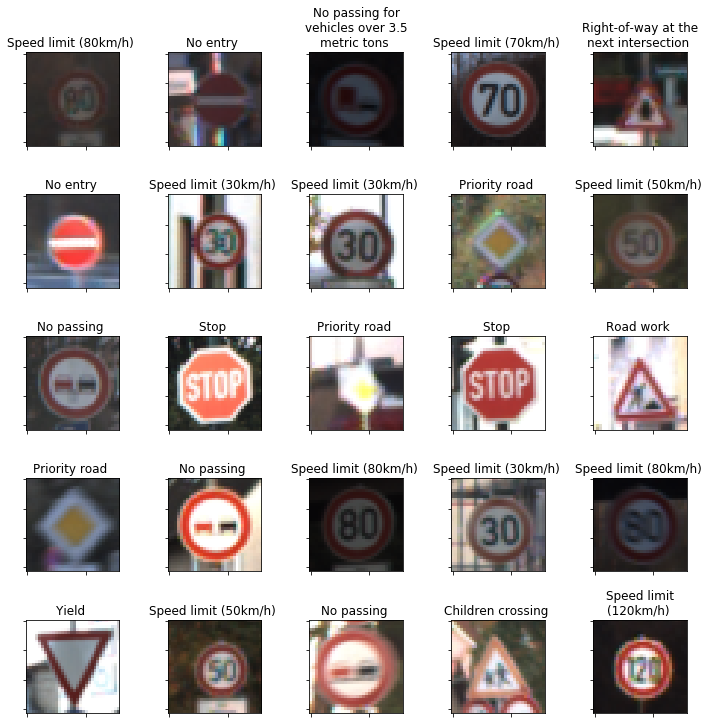

In [45]:
# Number of random examples from the training data to be displayed

n_examples = 25
n_cols = 5
n_rows = 5

# Select and display random training images

examples = np.random.randint(0, len(y_train), n_examples)
X_examples = X_train[examples]
y_examples = y_train[examples]

fig, sub = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,10))
fig.tight_layout()
sub = sub.flatten()
for index in range(len(examples)):
    sub[index].set(title="%s " % "\n".join(wrap(signname(y_examples[index]), 20)))
    sub[index].set_yticklabels([])
    sub[index].set_xticklabels([])
    sub[index].imshow(X_examples[index])


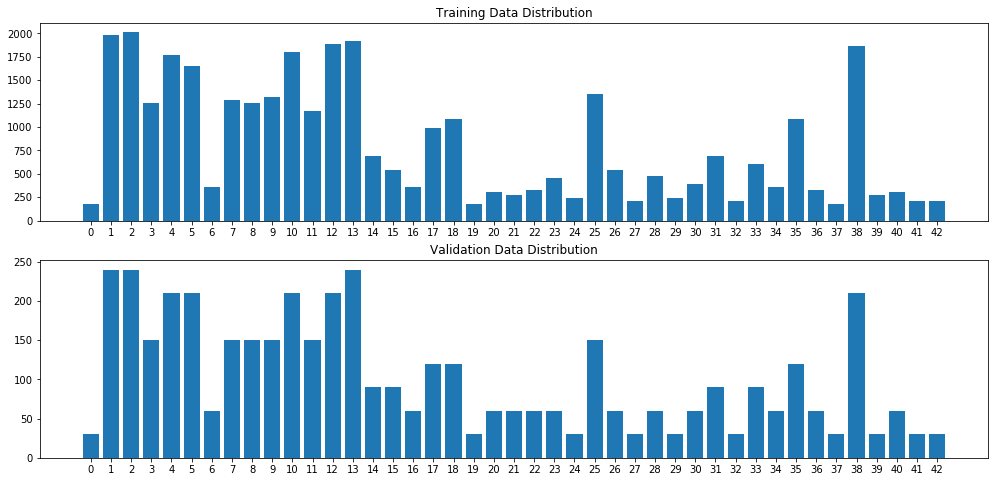

In [46]:
# Distribution of Training and Validation data

fig, (h_train, h_valid) = plt.subplots(nrows=2, ncols=1, figsize=(17,8))

train_bar = h_train.bar(range(43), np.unique(y_train, return_counts=True)[1])
train_ticks = h_train.set_xticks(range(43))
train_title = h_train.set_title("Training Data Distribution")

valid_bar = h_valid.bar(range(43), np.unique(y_valid, return_counts=True)[1])
valid_ticks = h_valid.set_xticks(range(43))
valid_title = h_valid.set_title("Validation Data Distribution")

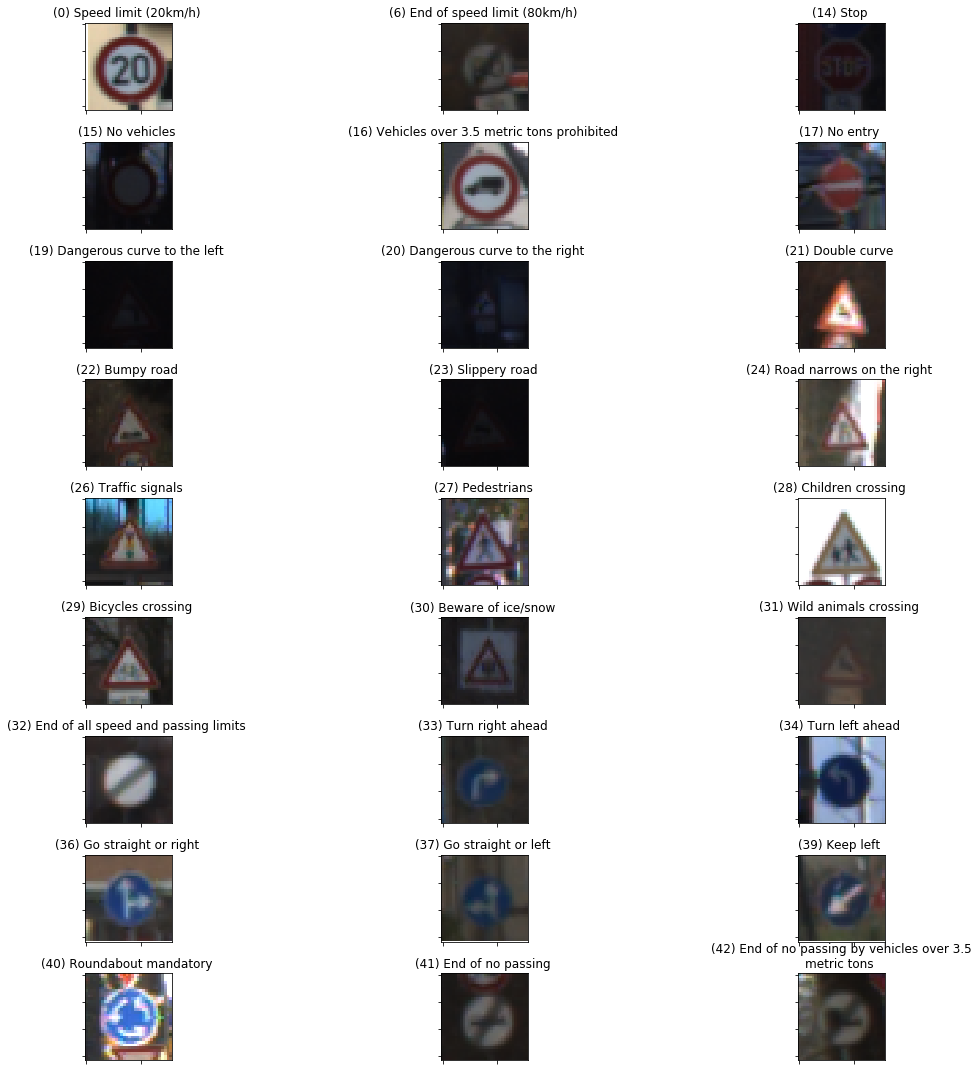

In [47]:
# Select a base count threshold for image augmentation
base = 1000

uniques, index, count = np.unique(y_train, return_index=True,return_counts=True)

# Get classes with image count below the selected base
below_threshold = [i for i in range(len(count)) if count[i] < base]

# Display one image of each class below the threshold

n_examples = len(below_threshold)
n_cols = 3
n_rows = 9

fig, sub = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,15))
fig.tight_layout()
sub = sub.flatten()
for i in range(n_examples):
    sub[i].set(title="(%i) %s " % (below_threshold[i], "\n".join(wrap(signname(below_threshold[i]), 40))))
    sub[i].set_yticklabels([])
    sub[i].set_xticklabels([])
    sub[i].imshow(X_train[index[below_threshold[i]]])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
# Increase the brightness of the image by a random value in the range [0, rnd_range)

def random_brightness(img, value_range=70):
    
    rnd = np.random.randint(low=0, high=value_range+1)
    
    # Conver to HSV and isolate the V channel
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img)
    v += rnd
    
    # Merge all channels and convery back to RGB
    img = cv2.merge((h, s, v))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    img = np.ndarray.astype(img, np.uint8)
    
    return img


In [9]:
# Rotate the image by a random value between degrees [-angle, angle]

def random_rotation(img, angle_range=10):
    
    rnd_angle = np.random.randint(-angle_range, angle_range+1)
    img = transform.rotate(img, rnd_angle, preserve_range=True)
    img = np.ndarray.astype(img, np.uint8)
    
    return img


In [50]:
# Method to augment images of the classes which are under-represented in the training data set

def augment_data(training_images, training_labels, base=1000):
    
    aug_images = []
    aug_labels = []
    
    # Select a base count threshold for image augmentation
    base = 1000
    
    # Get a count of images for all the output classes
    uniques, count = np.unique(training_labels, return_counts=True)

    # Get classes with image count below the selected base threshold
    below_threshold_classes = [i for i in range(len(count)) if count[i] < base]

    # Get the count of images for each class below the threshold
    below_threshold_count = [count[i] for i in below_threshold_classes]
    
    # Print information
    print("%i classes need to be augmented" % len(below_threshold_classes))
    print("%i images need to be generated" % (1000 * len(below_threshold_classes) - sum(below_threshold_count)))

    # For each class below the threshold, generate new images
    for i in range(len(below_threshold_classes)):
        
        # Output class to be augmented
        aug_class = below_threshold_classes[i]
        
        # Current number of images for this class
        current_img_count = below_threshold_count[i]
              
        # Get all indexes where this class is the output
        aug_class_indexes = np.where(training_labels==aug_class)[0]
             
        # While current count is less than the base threshold, generate new augmented images  
        while(current_img_count < base):
            
            # Select a random image from this class
            idx = np.random.choice(aug_class_indexes, 1)
            img = training_images[idx[0]]
            
            # Generate five augmented images by altering the rotation and brightness
            for j in range(5):
                imgcp = random_brightness(img, value_range=70)
                imgcp = random_rotation(imgcp, angle_range=10)
                aug_images.append(imgcp)
                aug_labels.append(aug_class)
                
            current_img_count+=5
            
    print("\nImages have been created")
    
    return np.array(aug_images), np.array(aug_labels)

In [51]:
# Augment the training data using the above methods

aug_images, aug_labels = augment_data(X_train, y_train)

27 classes need to be augmented
16891 images need to be generated

Images have been created


In [52]:
# Add the new data to the training data set

X_train = np.concatenate((X_train, aug_images))
y_train = np.concatenate((y_train, aug_labels))

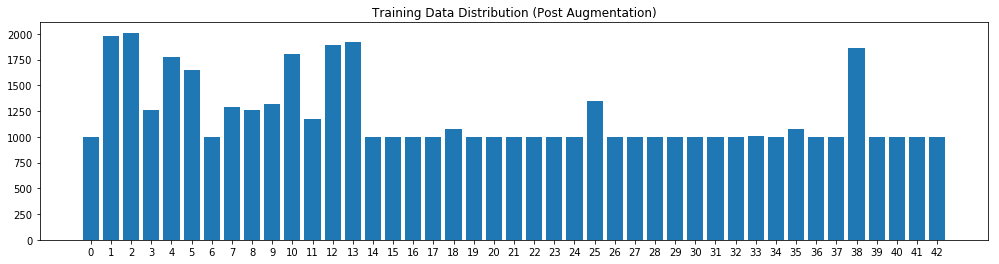

In [53]:
# Distribution of the training data after augmentation

plt.figure(figsize=(17,4))
plt.bar(range(43), np.unique(y_train, return_counts=True)[1])
plt.xticks(range(43))
p = plt.title("Training Data Distribution (Post Augmentation)")
    

In [54]:
# Converts images from RGB to Grayscale using skimage
# Output pixel values will be in the range [0,1]

def grayscale(images):
    
    #Output is reshaped to 32x32x1 as that is the required input for the ConvNet
    return np.array([np.reshape(skc.rgb2gray(img), (32, 32, 1)) for img in images])

In [5]:
# Normalizes pixel values using the mean and std values passed to the function

def normalize(images, m, s):    
    return (images - m) / s

In [56]:
# Preprocess the data using the helper methods

# Convert training, validation and test data to grayscale
X_train = grayscale(X_train)
X_valid = grayscale(X_valid)
X_test = grayscale(X_test)

# Calculate mean and std of the grayscaled training data
train_mean = np.mean(X_train)
train_std = np.std(X_train)

# Normalize training, validation and test data using mean and std of the training data
X_train = normalize(X_train, train_mean, train_std)
X_valid = normalize(X_valid, train_mean, train_std)
X_test = normalize(X_test, train_mean, train_std)

### Model Architecture

In [107]:
### Define your architecture here.

# The model is a modified version of LeNet Architecture
# There is an extra convolutional layer added (Noted here as Layer 2.5)
# Dropout is configured in the two fully connected layers

from tensorflow.contrib.layers import flatten

def ConvNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    w_conv_layer1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mu, sigma), name="L1_weight")
    b_conv_layer1 = tf.Variable(tf.truncated_normal([6], mu, sigma), name="L1_bias")
    strides = [1, 1, 1, 1]
    
    layer = tf.nn.conv2d(x, w_conv_layer1, strides, padding='VALID')
    layer = tf.nn.bias_add(layer, b_conv_layer1)
    
    #Activation.
    layer = tf.nn.relu(layer)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1, 2, 2, 1]
    layer = tf.nn.max_pool(layer, ksize=ksize, strides=ksize, padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    w_conv_layer2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma), name="L2_weight")
    b_conv_layer2 = tf.Variable(tf.truncated_normal([16], mu, sigma), name="L2_bias")
    strides = [1, 1, 1, 1]
    
    layer = tf.nn.conv2d(layer, w_conv_layer2, strides, padding='VALID')
    layer = tf.nn.bias_add(layer, b_conv_layer2)
    
    #Activation.
    layer = tf.nn.relu(layer)
         
    #Layer 2.5: Convolutional. Input = 10x10x16 Output = 10x10x16.
    w_conv_layer25 = tf.Variable(tf.truncated_normal([5, 5, 16, 16], mu, sigma), name="L2.5_weight")
    b_conv_layer25 = tf.Variable(tf.truncated_normal([16], mu, sigma), name="L2.5_bias")
    strides = [1, 1, 1, 1]
    
    layer = tf.nn.conv2d(layer, w_conv_layer25, strides, padding='SAME')
    layer = tf.nn.bias_add(layer, b_conv_layer25)
    
    # Activation.
    layer = tf.nn.relu(layer)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2, 1]
    layer = tf.nn.max_pool(layer, ksize=ksize, strides=ksize, padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    layer = tf.reshape(layer, [-1, 400])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w_full_layer1 = tf.Variable(tf.truncated_normal([400, 120], mu, sigma), name="L3_weight")
    b_full_layer1 = tf.Variable(tf.truncated_normal([120], mu, sigma), name="L3_bias")
    layer = tf.add(tf.matmul(layer, w_full_layer1), b_full_layer1)
    
    # Activation.
    layer = tf.nn.relu(layer)
    
    # Dropout (Modification of LeNet)
    layer = tf.nn.dropout(layer, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w_full_layer2 = tf.Variable(tf.truncated_normal([120, 84], mu, sigma), name="L4_weight")
    b_full_layer2 = tf.Variable(tf.truncated_normal([84], mu, sigma), name="L4_bias")
    layer = tf.add(tf.matmul(layer, w_full_layer2), b_full_layer2)
    
    # Activation.
    layer = tf.nn.relu(layer)
    
    # Dropout (Modification of LeNet)
    layer = tf.nn.dropout(layer, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w_full_layer3 = tf.Variable(tf.truncated_normal([84, 43], mu, sigma), name="L5_weight")
    b_full_layer3 = tf.Variable(tf.truncated_normal([43], mu, sigma), name="L5_bias")
    logits = tf.add(tf.matmul(layer, w_full_layer3), b_full_layer3)
    
    return logits

In [157]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name="ph_x")
y = tf.placeholder(tf.int32, (None), name="ph_y")
keep_prob = tf.placeholder(tf.float32, name="ph_keep_prob")
one_hot_y = tf.one_hot(y, 43)

# Variables for exponential decay of learning rate
global_step = tf.Variable(0, trainable=False)
initial_learning_rate = 0.001
decay_steps = 100
decay_rate = 0.9
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps,
                                          decay_rate, staircase=False)

logits = ConvNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = initial_learning_rate)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [161]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Set parameters and train the model
EPOCHS = 150
BATCH_SIZE = 512

train_accuracy_arr = []
valid_accuracy_arr = []
epochs_list = range(1,EPOCHS+1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(1, EPOCHS+1):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})       
        validation_accuracy = evaluate(X_valid, y_valid)      
        valid_accuracy_arr.append(validation_accuracy)
        
        if(i%10==0 or i==1): 
            
            print("EPOCH {} ...".format(i))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
    
    training_accuracy = evaluate(X_train, y_train)
    print("\n\nFinal Training Accuracy = {:.3f}".format(training_accuracy))
    print("Final Validation Accuracy = {:.3f}".format(validation_accuracy))
    print()
    
    saver.save(sess, './covnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.440

EPOCH 10 ...
Validation Accuracy = 0.935

EPOCH 20 ...
Validation Accuracy = 0.956

EPOCH 30 ...
Validation Accuracy = 0.959

EPOCH 40 ...
Validation Accuracy = 0.959

EPOCH 50 ...
Validation Accuracy = 0.958

EPOCH 60 ...
Validation Accuracy = 0.967

EPOCH 70 ...
Validation Accuracy = 0.967

EPOCH 80 ...
Validation Accuracy = 0.957

EPOCH 90 ...
Validation Accuracy = 0.967

EPOCH 100 ...
Validation Accuracy = 0.970

EPOCH 110 ...
Validation Accuracy = 0.965

EPOCH 120 ...
Validation Accuracy = 0.973

EPOCH 130 ...
Validation Accuracy = 0.974

EPOCH 140 ...
Validation Accuracy = 0.968

EPOCH 150 ...
Validation Accuracy = 0.971



Final Training Accuracy = 0.999
Final Validation Accuracy = 0.971

Model saved


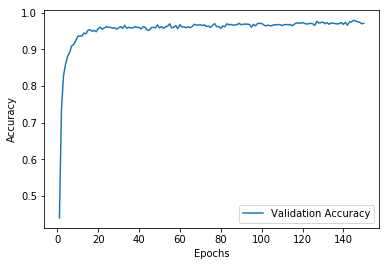

In [162]:
#Display the final Validation Accuracy

plt.plot(epochs_list, valid_accuracy_arr)
p = plt.legend(("Validation Accuracy",), loc="lower right")
p = plt.ylabel("Accuracy")
p = plt.xlabel("Epochs")

In [172]:
# Evaluation of the Test Accuracy

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [164]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

w_img1 = mpimg.imread("web-images/02.jpg")
w_img2 = mpimg.imread("web-images/100_1607.jpg")
w_img3 = mpimg.imread("web-images/Arterial.jpg")
w_img4 = mpimg.imread("web-images/Stop sign.jpg")
w_img5 = mpimg.imread("web-images/turn_left.jpg")

X_web = [w_img1, w_img2, w_img3, w_img4, w_img5]
y_web = np.array([25, 11, 12, 14, 34])

# Resize

X_web = np.array([transform.resize(img, (32, 32, 3), mode='reflect') for img in X_web])

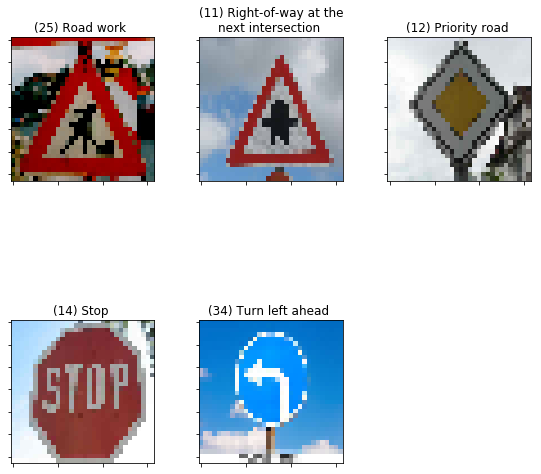

In [165]:
# Display images obtained from the web

fig, sub = plt.subplots(nrows=2, ncols=3, figsize=(8,8))
fig.tight_layout()
sub = sub.flatten()
for i in range(5):
    sub[i].set(title="(%i) %s " % (y_web[i], "\n".join(wrap(signname(y_web[i]), 20))))
    sub[i].set_yticklabels([])
    sub[i].set_xticklabels([])
    sub[i].imshow(X_web[i])
sub[5].set_visible(False)


### Predict the Sign Type for Each Image

In [166]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# Convert to grayscale
X_web = grayscale(X_web)

# Normalize using the mean and std calculated over the training data set
X_web = normalize(X_web, train_mean, train_std)

In [167]:
# Use saved model to predict images and display the results

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    prediction = sess.run(correct_prediction, feed_dict={x: X_web, y: y_web, keep_prob:1.0})

for i in range(len(prediction)):
    print("Web Image %i: %s - Class %i (%s)"
         % (i, "CORRECTLY Predicted" if prediction[i] else "INCORRECTLY Predicted", y_web[i], signname(y_web[i])))

Web Image 0: INCORRECTLY Predicted - Class 25 (Road work)
Web Image 1: CORRECTLY Predicted - Class 11 (Right-of-way at the next intersection)
Web Image 2: CORRECTLY Predicted - Class 12 (Priority road)
Web Image 3: CORRECTLY Predicted - Class 14 (Stop)
Web Image 4: CORRECTLY Predicted - Class 34 (Turn left ahead)


### Analyze Performance

In [168]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

web_accuracy = np.count_nonzero(prediction)
web_accuracy = 100*web_accuracy/len(prediction)

print("The prediction accuracy for web images is {:4.2f} %".format(web_accuracy))

The prediction accuracy for web images is 80.00 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [176]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output = tf.Variable(0)
    output = sess.run(logits, feed_dict={x: X_web, y: y_web, keep_prob:1.0})
    top_softmax = sess.run(tf.nn.top_k(tf.constant(output), k=5))

In [192]:
print(top_softmax)

TopKV2(values=array([[  7.4069047 ,   6.67627144,   5.42645025,   2.42298746,
          2.13772869],
       [ 17.847826  ,   9.79014015,   3.70913982,   1.67196751,  -3.1900177 ],
       [ 18.75662422,   2.39500737,   1.09181571,   0.57200861,
          0.47022563],
       [ 25.6338501 ,  12.57922268,  12.2198019 ,   9.86944294,
          4.58517361],
       [  6.03520966,   3.94222355,   1.78044367,   1.53458333,
          0.05520439]], dtype=float32), indices=array([[18, 26, 20, 24, 28],
       [11, 18, 30, 27, 12],
       [12, 13, 32,  8, 15],
       [14, 39, 13, 32,  0],
       [34, 13, 14, 32, 38]], dtype=int32))


In [197]:
for i in range(len(y_web)):
    print("\nFor Web Image %i: %s - Class %i (%s)"
         % (i, "CORRECTLY Predicted" if prediction[i] else "INCORRECTLY Predicted", y_web[i], signname(y_web[i])))
    print("--Top 5 probabilities are--")
    print("{:5.3f} - Class {} : {}".format(top_softmax[0][i][0], top_softmax[1][i][0], signname(top_softmax[1][i][0])))
    print("{:5.3f} - Class {} : {}".format(top_softmax[0][i][1], top_softmax[1][i][1], signname(top_softmax[1][i][1])))
    print("{:5.3f} - Class {} : {}".format(top_softmax[0][i][2], top_softmax[1][i][2], signname(top_softmax[1][i][2])))
    print("{:5.3f} - Class {} : {}".format(top_softmax[0][i][3], top_softmax[1][i][3], signname(top_softmax[1][i][3])))
    print("{:5.3f} - Class {} : {}".format(top_softmax[0][i][4], top_softmax[1][i][4], signname(top_softmax[1][i][4])))


For Web Image 0: INCORRECTLY Predicted - Class 25 (Road work)
--Top 5 probabilities are--
7.407 - Class 18 : General caution
6.676 - Class 26 : Traffic signals
5.426 - Class 20 : Dangerous curve to the right
2.423 - Class 24 : Road narrows on the right
2.138 - Class 28 : Children crossing

For Web Image 1: CORRECTLY Predicted - Class 11 (Right-of-way at the next intersection)
--Top 5 probabilities are--
17.848 - Class 11 : Right-of-way at the next intersection
9.790 - Class 18 : General caution
3.709 - Class 30 : Beware of ice/snow
1.672 - Class 27 : Pedestrians
-3.190 - Class 12 : Priority road

For Web Image 2: CORRECTLY Predicted - Class 12 (Priority road)
--Top 5 probabilities are--
18.757 - Class 12 : Priority road
2.395 - Class 13 : Yield
1.092 - Class 32 : End of all speed and passing limits
0.572 - Class 8 : Speed limit (120km/h)
0.470 - Class 15 : No vehicles

For Web Image 3: CORRECTLY Predicted - Class 14 (Stop)
--Top 5 probabilities are--
25.634 - Class 14 : Stop
12.579 - 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

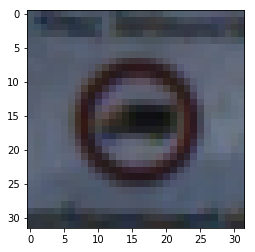

In [10]:
plt.imshow(X_train[5050])